In [1]:
# import the necessary packages
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import glob
import cv2
import os
import csv

## Modules to check the performance of the code
from time import process_time 
# !pip install memory_profiler ## When running from Google Colab
# import memory_profiler as mem_profile
# print('Memory (Before): {}Mb'.format(mem_profile.memory_usage()))


## Importing the necessary TesnorFLow modules modules
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

# from tensorflow.python.compiler.mlcompute import mlcompute
# mlcompute.set_mlc_device(device_name='gpu')

from tensorflow import keras
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model
from sklearn.metrics import r2_score ## form calcualting the r2 score
from sklearn.utils import shuffle
from tensorflow import keras as k

In [2]:
############ Please provide the same path to the code directory if using Colab################

# Path_gdrive= '/content/drive/MyDrive/DPNNet-RT/' ## Comment out this line if using local computer

## Importing the Modules from Modules_DPNNet
import sys
try: ## tries to find the modules in the local directory first
  current_directory = os.getcwd()
  path = current_directory + '/' # For local computer 
#   path = '' # For local computer  
  sys.path.append(path+'MODULES_DPNNeT')
  import data_processing_RT as dp
  import deep_models as dm
  import other_cnns as ocn

########### Folders to save the processed data, files and figures when using Local computer ##############
  output_folder_list = ['data_folder','figures','saved_model']
  for file in output_folder_list:
    try:
        os.makedirs(file)
    except OSError:
        print ("Creation of the directory %s failed/ not needed as it already exit" % file)
    else:
        print ("Successfully created the directory %s" % file)
  
except ModuleNotFoundError:
  
  # #For Colab use:
  # #Point to the path containing the modules in the above section
  #(data folder are a directory above the directory containing the notebook)
  try:
    path = Path_gdrive
    print(path)
    sys.path.append(path+'MODULES_DPNNeT')
    import data_processing_RT as dp
    import deep_models as dm
    import other_cnns as ocn

    ########### Folders to save the processed data, files and figures when using GDRIVE ##############
    import os
    os.chdir(path)
    print("Creating the folders")
    !mkdir -p data_folder
    !mkdir -p figures ## to save the figures
    !mkdir -p figures_paper
    !mkdir -p saved_model
  except ModuleNotFoundError:
    print("The path to the modules is incorrect-- Provide current path")

print("[INFO] Modules imported")



We are currently using the Modules_DPCNet-RT
Creation of the directory data_folder failed/ not needed as it already exit
Creation of the directory figures failed/ not needed as it already exit
Creation of the directory saved_model failed/ not needed as it already exit
[INFO] Modules imported


In [3]:
test = pd.read_csv("data_folder/test_dataset.csv")
train = pd.read_csv("data_folder/train_dataset.csv")
## Generate the Normalized data
normed_train_data, normed_test_data, train_labels, test_labels = dp.process_the_disk_attributes(train, test, path,multi_label=True)
### Desired Image resoltuion #####
X_res = Y_res = 64
testImagesX = dp.load_disk_images(test, X_res, Y_res, Type = "Test")

[INFO] preparing the normalized data training/testing split...
Droping the irrelevant columns 
INFO: considering multiple planets as output
[INFO] Done...
[INFO] Loading images from Test data..
Test Images are loaded


In [4]:
from tensorflow.keras import layers
from tensorflow.keras.applications import EfficientNetB0, EfficientNetB1 
from tensorflow.keras.applications import EfficientNetB2, EfficientNetB3
from tensorflow.keras.applications import EfficientNetB4, EfficientNetB5 
from tensorflow.keras.applications import EfficientNetB6, EfficientNetB7
from tensorflow.keras.applications import ResNet50,ResNet50V2
## Select the Network type

# NETWORK = "Vanilla" ## Cannot be uses at the moment
# NETWORK = "ALEXNET"
# NETWORK = "VGG"
# NETWORK = "RESNET50"
# NETWORK = "TL"
# # transfer_model=ResNet50
# transfer_model=EfficientNetB3


NETWORK = "TRANSFERLEARNINGHYPERMODEL"
transfer_model = ResNet50

## Select the kind of Traning ## Both can be selected as well
# REG = True  ## When choosing regression
# CLA = False  ## When Choosing Clasiffication

REG = True  ## When choosing regression
CLA = True  ## When Choosing Clasiffication


In [5]:
# # Loading the model
# if REG == True and CLA == True:
#     CNN = tf.keras.models.load_model(path+'saved_model/'+NETWORK+'_'+str(X_res)+'_modelRC')
# elif REG == True:
#     CNN = tf.keras.models.load_model(path+'saved_model/'+NETWORK+'_'+str(X_res)+'_modelR')
# elif CLA == True:
#     CNN = tf.keras.models.load_model(path+'saved_model/'+NETWORK+'_'+str(X_res)+'_modelC')


2022-09-22 14:58:40.361455: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-22 14:58:42.101409: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 11319 MB memory:  -> device: 0, name: Tesla P100-PCIE-12GB, pci bus id: 0000:04:00.0, compute capability: 6.0


ValueError: Unknown loss function: pmae. Please ensure this object is passed to the `custom_objects` argument. See https://www.tensorflow.org/guide/keras/save_and_serialize#registering_the_custom_object for details.

In [7]:
### For customized loss function we need to use the following code snippet
### This needs to be later moved to the module folder

def pmae(y_true, y_pred):
              if not tf.is_tensor(y_pred):
                  y_pred = K.constant(y_pred)
              y_true = K.cast(y_true, y_pred.dtype)
              diff = K.mean(K.abs((y_pred - y_true)) / K.mean(K.clip(K.abs(y_true),
                                                                    K.epsilon(),
                                                                    None)))
              return K.mean(diff)          
# Loading the model
if REG == True and CLA == True:
    CNN = tf.keras.models.load_model(path+'saved_model/'+NETWORK+'_'+str(X_res)+'_modelRC', custom_objects={'pmae': pmae})
elif REG == True:
    CNN = tf.keras.models.load_model(path+'saved_model/'+NETWORK+'_'+str(X_res)+'_modelR')
elif CLA == True:
    CNN = tf.keras.models.load_model(path+'saved_model/'+NETWORK+'_'+str(X_res)+'_modelR')

In [29]:
test_index = 560 #451 #550 ##210
pred_CNN = CNN.predict(testImagesX)
# np.shape(pred_CNN)
print(pred_CNN[1][test_index])
print(pred_CNN[0][test_index])

# pred_CNN[test_index]

71/71 [==============================] - 1s 17ms/step
[0.9984946  0.99941444]
[675.06696 569.48535 781.8097 ]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Planet_Mass1    616.666667
Planet_Mass2    650.000000
Planet_Mass3    903.333333
Name: 560, dtype: float64

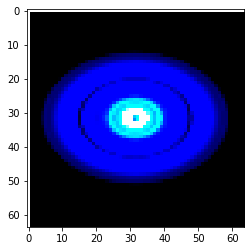

In [30]:
plt.imshow(testImagesX[test_index])
test_labels.iloc[test_index]